In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:

train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer Binary/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 128)
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer Binary/valid',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 128)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.



100%|██████████| 5/5 [02:12<00:00, 26.47s/it]


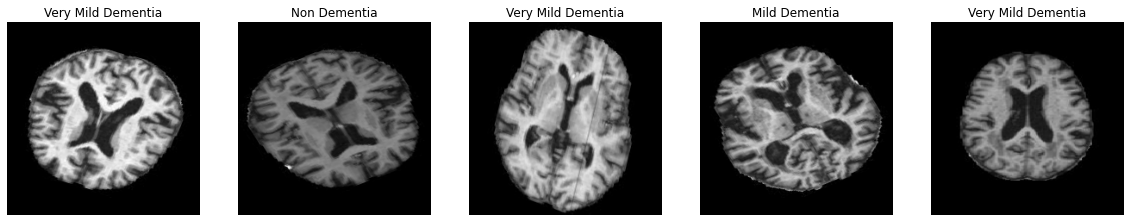

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand_int1 = np.random.randint(len(train_dataset))
    rand_int2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand_int1][0][rand_int2])
    ax[i].axis('off')
    a = train_dataset[rand_int1][1][rand_int2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [ ]:
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")
for layer in base_model.layers:
    layer.trainable=False

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

model.summary()

51879936/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1664)        0         
_________________________________________________________________
flatten (Flatten)            (None, 81536)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 81536)             326144    
_________________________________________________________________
dense (Dense)                (None, 2048)              166987776 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________

In [ ]:
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

filepath = '/content/drive/MyDrive/alzheimer_densenet169.h5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
41/41 [==============================] - 1247s 29s/step - loss: 1.4837 - auc: 0.7460 - val_loss: 1.5984 - val_auc: 0.8106

Epoch 00001: val_auc improved from -inf to 0.81063, saving model to /content/drive/MyDrive/alzheimer_densenet169.h5
Epoch 2/500
41/41 [==============================] - 84s 2s/step - loss: 1.1153 - auc: 0.8194 - val_loss: 1.0244 - val_auc: 0.8513

Epoch 00002: val_auc improved from 0.81063 to 0.85125, saving model to /content/drive/MyDrive/alzheimer_densenet169.h5
Epoch 3/500
41/41 [==============================] - 85s 2s/step - loss: 1.0002 - auc: 0.8401 - val_loss: 1.0128 - val_auc: 0.8536

Epoch 00003: val_auc improved from 0.85125 to 0.85356, saving model to /content/drive/MyDrive/alzheimer_densenet169.h5
Epoch 4/500
41/41 [==============================] - 82s 2s/step - loss: 0.8839 - auc: 0.8641 - val_loss: 0.9071 - val_auc: 0.8642

Epoch 00004: val_auc improved from 0.85356 to 0.86421, saving model to /content/drive/MyDrive/alzheimer_densenet169

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_dataset)

10/10 [==============================] - 5s 428ms/step - loss: 0.9817 - auc: 0.8848


[0.9816824197769165, 0.8848331570625305]

In [ ]:
filepath='/content/drive/MyDrive/alzheimer_densenet169.h5'
from tensorflow import keras
model = keras.models.load_model(filepath)

In [ ]:
target_names = []

for key in train_dataset.class_indices:

    target_names.append(key)
print(target_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
predict = model.predict_generator(valid_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
y_pred = np.argmax(predict, axis=1)

print('Confusion Matrix')
from sklearn.metrics import classification_report,confusion_matrix
cm = confusion_matrix(valid_dataset.classes, y_pred)
print(cm)

import itertools
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')


# **Flask Deployment using ngrok**

In [ ]:
!pip install flask-ngrok

In [ ]:
%mkdir templates -p
%mkdir static/css -p
%mkdir static/js -p
%mkdir uploads -p


In [ ]:
from __future__ import division, print_function
#coding=utf-8

import sys
import os
import glob
import re
import numpy as np
#flask
from flask import Flask
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename
from flask_ngrok import run_with_ngrok

#from gevent.pywsgi import WSGIServer

# Keras
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image

app = Flask(__name__)
run_with_ngrok(app) 

MODEL_PATH = '/content/drive/MyDrive/alzheimer_densenet169.h5'
model = load_model(MODEL_PATH)
print('Model loaded. Start serving...')

def model_predict(img_path, model):
  new_img = image.load_img(img_path, target_size=(224, 224))
  img = image.img_to_array(new_img)
  img = np.expand_dims(img, axis=0)
  img = img/255
  prediction = model.predict(img)
  d = prediction.flatten()
  j = d.max()
  #li = ['Cassava Bacterial Blight','Cassava Brown Streak Disease','Cassava Green Mottle','Cassava Mossaic Disease','Healthy']
  for index,item in enumerate(d):
    if item == j:
        class_name = target_names[index]
  return class_name

@app.route('/', methods=['GET'])
def index():
    # Main page
    return render_template('index.html')

@app.route('/predict', methods=['GET', 'POST'])
def upload():
    if request.method == 'POST':
        # Get the file from post request
        f = request.files['file']

        # Save the file to ./uploads
        basepath = '/content/'
        file_path = os.path.join(
            basepath, 'uploads', secure_filename(f.filename))
        f.save(file_path)

        # Make prediction
        result = model_predict(file_path, model)
              # Convert to string
        return result
    return None


app.run()


Model loaded. Start serving...
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://e60b64d11321.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [18/Apr/2021 14:04:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:04:42] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [18/Apr/2021 14:04:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:04:53] "GET /static/css/main.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:04:53] "GET /static/js/main.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:04:54] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [18/Apr/2021 14:05:46] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:06:29] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:06:50] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:07:17] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:07:42] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:07:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:07:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:08:24] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2021 14:09:22] "GET / HTTP/1.1" 